# Ideas throughout the notebook

* Alter the batchsize
* Add or remove the max pooling layer 
* Add or remove the residual block
* Change the learning rate

# Importing necessary libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as tt
from sklearn.utils import shuffle
import torchinfo
import torcheval
from torcheval.metrics import BinaryAccuracy
from tqdm import tqdm

height, width = 224, 224

#### Let's set up our device too.
#### We'll utilize the GPU available on Kaggle.

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
device

device(type='cuda', index=0)

# Creating custom dataset

##### With Deep Learning, preparing our data in the right format is the first step anyone should take.
##### Preparing the dataset correctly will go a long way, eliminating any possible errors throughout the journey.
##### I have prepared a custom dataset that has split the training and testing set accordingly.
##### This is good practice for a PyTorch custom dataset.

In [6]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = tt.Compose([
    tt.Resize((height, width)),
    tt.TrivialAugmentWide(num_magnitude_bins=31),
    tt.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = tt.Compose([
    tt.Resize((height, width)),
    tt.ToTensor()
])

In [7]:
from glob import glob
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.transform = transform
        
        labels = [[1,0] for i in range(len(self.no_class))]
        labels += [[0,1] for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class) + len(self.yes_class)
    
    def __getitem__(self, idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = torch.tensor(label_list, dtype=torch.float)
            
        for image in image_list:
            img = Image.open(image)
            
        return self.transform(img), label_list
                

In [8]:
train_data_custom = BrainTumorDataset("/kaggle/input/tumor-detection-custom-dataset/brain_tumor_data/train", transform = train_transform_trivial_augment)
test_data_custom = BrainTumorDataset("/kaggle/input/tumor-detection-custom-dataset/brain_tumor_data/test", transform = test_transform)

In [9]:
print(f"We have {len(train_data_custom)} training datapoints and {len(test_data_custom)} testing datapoints")

We have 160 training datapoints and 93 testing datapoints


## Custom DataLoaders

In [10]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=1, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fd667e5d290>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd66e6a3a50>)

##### Let's check whether our DataLoader is working properly.

In [11]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1, 2])


##### I discovered along this notebook that there are some pictures where the color channels are not 3.
##### Let's see how many of these errenous pictures there are.

In [12]:
count = 0

for batch, (X,y) in enumerate(train_dataloader_custom):
    if (X.shape[1] != 3):
        count += 1
        
for batch, (X,y) in enumerate(test_dataloader_custom):
    if (X.shape[1] != 3):
        count += 1
        
print(count)
print(f"\nThere are {count/(len(train_dataloader_custom) + len(test_dataloader_custom))*100:.1f}% of errenous pictures")

36

There are 14.2% of errenous pictures


##### 14% of the original data seem to be useless to us. 
#### We will just throw away these errenous data rather than unifying all the color channels to a single one.

# Neural Network Creation

##### For image classification, I will be utilizing CNN with residual blocks. 

In [13]:
class Basic_CNN(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 224 * 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 112 * 112 
                         stride=2)
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.Conv2d(hidden_shape, hidden_shape, 3, 1, 1), # hidden * 112 * 112 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # hidden * 56 * 56 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_shape * 56 * 56, output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.conv_2(self.conv_1(x)))
    
torch.manual_seed(42)
basic_model = Basic_CNN(3,32,2)
basic_model.to(device)
torchinfo.summary(basic_model, input_size=[1, 3, height, width])

Layer (type:depth-idx)                   Output Shape              Param #
Basic_CNN                                [1, 2]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 32, 224, 224]         9,248
│    └─ReLU: 2-4                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-7                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-9                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 32, 56, 56]           --
├─Seq

In [14]:
class CNN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(input_shape, 64, kernel_size = 7, stride = 1), # 64 * 218 * 218
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 64 * 109 * 109
        )
        
        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 64, 1, 1), # 64 * 109 * 109
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), # 64 * 107 * 107
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 1, 1), # 256 * 107 * 107
            nn.BatchNorm2d(256)
        )
        self.residual_conv_2 = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1),
            nn.BatchNorm2d(256)
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(256, 128, 1, 1), # 128 * 107 * 107
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1), # 128 * 105 * 105
            nn.BatchNorm2d(128),
        )
        self.residual_conv_3 = nn.Sequential(
            
            nn.Conv2d(256, 128, 3, 1),
            nn.BatchNorm2d(128)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(128 * 105 * 105, output_shape)
        )
        
        self.relu = nn.Sequential(
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.conv_1(x)
        out = self.conv_2(out) + self.residual_conv_2(out)
        out = self.relu(out)
        out = self.conv_3(out) + self.residual_conv_3(out)
        out = self.relu(out)
        return self.classifier(out)
    
torch.manual_seed(42)
model = CNN(3,2)
model.to(device)
torchinfo.summary(model, input_size=[1, 3, height, width])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 109, 109]         --
│    └─Conv2d: 2-1                       [1, 64, 218, 218]         9,472
│    └─BatchNorm2d: 2-2                  [1, 64, 218, 218]         128
│    └─ReLU: 2-3                         [1, 64, 218, 218]         --
│    └─MaxPool2d: 2-4                    [1, 64, 109, 109]         --
├─Sequential: 1-2                        [1, 256, 107, 107]        --
│    └─Conv2d: 2-5                       [1, 64, 109, 109]         4,160
│    └─BatchNorm2d: 2-6                  [1, 64, 109, 109]         128
│    └─ReLU: 2-7                         [1, 64, 109, 109]         --
│    └─Conv2d: 2-8                       [1, 64, 107, 107]         36,928
│    └─BatchNorm2d: 2-9                  [1, 64, 107, 107]         128
│    └─ReLU: 2-10                        [1, 64, 107, 107]         --
│ 

##### Now, let's create our training and testing loop.

# Training and Testing loop (Simple)

In [15]:
lf = nn.BCEWithLogitsLoss() # Adding the sigmoid function as well
optimizer = torch.optim.SGD(params = basic_model.parameters(), lr = 0.01)

In [16]:
epochs = 100
acc_fn = BinaryAccuracy().to(device)
train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
        
        if (X.shape[1] != 3): # Skipping over pictures with only 1 color channels
            continue
            
        X = X.to(device)
        y = y.to(device)
        basic_model.train()
        
        # Forward
        y_pred = basic_model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            if (X.shape[1] != 3): # Skipping over pictures with only 1 color channels
                continue
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = basic_model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            acc_fn.update(test_pred.argmax(dim=1).to(device), y.argmax(dim=1).to(device))
            test_acc += acc_fn.compute()
            
        test_loss /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(test_dataloader_custom)
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")



Epoch: 0 | Train loss: 0.61989 | Test loss: 0.51985, Test acc: 50.14%


Epoch: 1 | Train loss: 0.60576 | Test loss: 0.49331, Test acc: 48.05%


Epoch: 2 | Train loss: 0.59610 | Test loss: 0.46653, Test acc: 47.76%


Epoch: 3 | Train loss: 0.57342 | Test loss: 0.47051, Test acc: 48.32%


Epoch: 4 | Train loss: 0.56876 | Test loss: 0.45607, Test acc: 49.54%


Epoch: 5 | Train loss: 0.55212 | Test loss: 0.45212, Test acc: 50.70%


Epoch: 6 | Train loss: 0.51099 | Test loss: 0.43147, Test acc: 52.02%


Epoch: 7 | Train loss: 0.52693 | Test loss: 0.42157, Test acc: 52.81%


Epoch: 8 | Train loss: 0.51058 | Test loss: 0.46035, Test acc: 53.22%


Epoch: 9 | Train loss: 0.51200 | Test loss: 0.39815, Test acc: 53.55%


Epoch: 10 | Train loss: 0.50257 | Test loss: 0.37881, Test acc: 54.05%


Epoch: 11 | Train loss: 0.50016 | Test loss: 0.43955, Test acc: 54.49%


Epoch: 12 | Train loss: 0.53405 | Test loss: 1.30836, Test acc: 53.54%


Epoch: 13 | Train loss: 0.50507 | Test loss: 0.35598, Test a

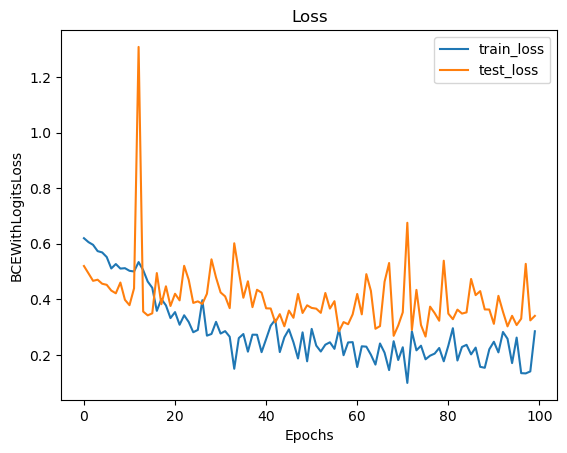

In [17]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train_loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCEWithLogitsLoss')
plt.legend();

# Training and Testing loop (ResNet50 inspired)

In [18]:
lf = nn.BCEWithLogitsLoss() # Adding the sigmoid function as well
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.005)

In [19]:
epochs = 50
acc_fn = BinaryAccuracy().to(device)
train_loss_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):
    train_loss = 0
    
    for batch, (X,y) in enumerate(train_dataloader_custom):
        
        if (X.shape[1] != 3): # Skipping over pictures with only 1 color channels
            continue
            
        X = X.to(device)
        y = y.to(device)
        model.train()
        
        # Forward
        y_pred = model(X)
        
        # Calculate loss
        loss = lf(y_pred, y)
        train_loss += loss
        
        # Zero grad
        optimizer.zero_grad()
        
        # Loss backward
        loss.backward()
        
        # Optimizer step
        optimizer.step()
    
    train_loss/=len(train_dataloader_custom)
    train_loss_arr.append(train_loss.cpu().detach().numpy())
    
    test_loss, test_acc= 0, 0
    model.eval() 
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader_custom):
            
            if (X.shape[1] != 3): # Skipping over pictures with only 1 color channels
                continue
            
            X = X.to(device)
            y = y.to(device)
            
            # Forward
            test_pred = model(X)
            
            # Calculate loss 
            test_loss += lf(test_pred, y)
            
            # Calculate accuracy 
            acc_fn.update(test_pred.argmax(dim=1).to(device), y.argmax(dim=1).to(device))
            test_acc += acc_fn.compute()
            
        test_loss /= len(test_dataloader_custom)
        test_loss_arr.append(test_loss.cpu().detach().numpy())
        test_acc /= len(test_dataloader_custom)
        test_acc_arr.append(test_acc.cpu().detach().numpy())
        
    print(f"\nEpoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc*100:.2f}%\n")



Epoch: 0 | Train loss: 37.49438 | Test loss: 1.22911, Test acc: 51.41%


Epoch: 1 | Train loss: 0.61303 | Test loss: 0.61457, Test acc: 46.50%


Epoch: 2 | Train loss: 0.44913 | Test loss: 1.36350, Test acc: 45.61%


Epoch: 3 | Train loss: 0.42122 | Test loss: 1.42785, Test acc: 45.64%


Epoch: 4 | Train loss: 0.35927 | Test loss: 0.98652, Test acc: 46.87%


Epoch: 5 | Train loss: 0.37539 | Test loss: 0.61170, Test acc: 48.37%


Epoch: 6 | Train loss: 0.19751 | Test loss: 0.98332, Test acc: 49.92%


Epoch: 7 | Train loss: 0.36337 | Test loss: 1.03433, Test acc: 50.66%


Epoch: 8 | Train loss: 0.28067 | Test loss: 0.79382, Test acc: 50.78%


Epoch: 9 | Train loss: 0.34311 | Test loss: 1.23460, Test acc: 50.59%


Epoch: 10 | Train loss: 0.35033 | Test loss: 0.62205, Test acc: 50.41%


Epoch: 11 | Train loss: 0.28625 | Test loss: 0.55131, Test acc: 50.37%


Epoch: 12 | Train loss: 0.23491 | Test loss: 0.66979, Test acc: 50.65%


Epoch: 13 | Train loss: 0.19807 | Test loss: 0.58862, Test 

## Plotting the train and test loss

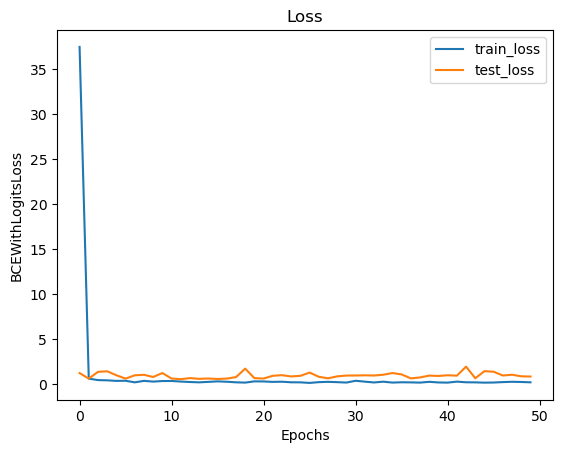

In [20]:
plt.plot([i for i in range(epochs)], train_loss_arr, label='train_loss')
plt.plot([i for i in range(epochs)], test_loss_arr, label='test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('BCEWithLogitsLoss')
plt.legend();

### Conclusion

##### It seems like with the ResNet50 inspired model, if we run the training for more epochs, we will run into the problem of overfitting. 
##### On the contrary, the simpler, basic model seems to show more promise. 
##### However, I don't think the accuracy would be substantially higher than about 60%.


### The **main problem** I believe is the lack of data. 


##### We only have just over 200 data and this is not enough for any deep learning task, unless we are talking about transferred learning.
##### The problem that we can solve as of now should be with improvement of model architecture and data augmentation.
##### Hopefully you will be motivated to try out different approaches!

### If you liked this notebook and found the approach helpful and useful, please do upvote. 
### It goes a long way!
### Cheers!